# TroMoM
### Tropical Mosquito Monitor

In this notebook, we read the preprocessed data as if the data were provided by the customer.
Then, the data gets analyzed and further processed to the point of outputting the hazard map.

The processing steps, as specified in the project plan, are the following:


![](data_flow.png)

### Imports

In [88]:
import os

import numpy as np
import matplotlib.pyplot as plt

import rasterio

### Read Data
As a first step, read preprocessed analysis-ready data from file.

In [62]:
""" Expected data structure

<area_name>_EPSG<epsg>_<date:YYYY-MM-DD> (one folder per sample, defined by time and area)
|
|- surface_temperature.tiff
|- soil_moisture.tiff
|- ndvi.tiff
|- population_density.tiff
"""
dir_data = "data/processed/borneo_EPSG4326_2023-02-15"    # example data directory


def read_data(data_dir_list):
    out = []
    for data_dir in data_dir_list:
        temp = rasterio.open(os.path.join(data_dir, "surface_temperature.tiff"))
        moist = rasterio.open(os.path.join(data_dir, "soil_moisture.tiff"))
        ndvi = rasterio.open(os.path.join(data_dir, "ndvi.tiff"))
        pop = rasterio.open(os.path.join(data_dir, "population_density.tiff"))

        print(temp.shape, type(temp))

        out.append(np.concatenate((moist, temp, ndvi, pop)))

    return out

In [63]:
data_dir_list = os.listdir("data/processed")
# optionally provide spatial/temporal filtering options

data = read_data(data_dir_list)     # a list of stacked data samples

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'data/processed'

### Process Data
Now, the actual processing for our product starts, following the data flow specified at the top.
The simplest algorithm would be to threshold all data layers separately, so we specify the necessary thresholds.

In [111]:
# need to be determined by research/looking at example values in swampy areas

# example values, typical values need to be determined after download of data
thresh_temp = [20, 35]
thresh_moisture = [.3, .9]
thresh_ndvi = [.3, 1]
thresh_pop = [.1, 1]

threshs = [thresh_temp, thresh_moisture, thresh_ndvi, thresh_pop]

In [72]:
def classify_b___ooooooold_y_threshold(data_list, *threshs):
    print(threshs)
    out = []
    for data in data_list:
        print("data:", data.shape)
        assert data.shape[0] == len(threshs), "Number of thresholds must equal number of data layers."
        classif = np.zeros(data.shape[:2])  # output per sample

        for i, layer_, thresh_ in enumerate(zip(data, threshs)):
            lower, upper = thresh_
            classif[layer_ > lower & layer_ < upper] += 10**i   # keep track which conditions are met

        out.append(classif)

    return out

#### Create test data
A simple dummy input is created to test the processing/classification algorithm.
All possible outcome states are created.

In [103]:
from itertools import product

def create_test_data(*threshs):
    # print(threshs)
    num_decisions = len(threshs)
    num_outcomes = 2**num_decisions


    num_rows = int(np.ceil(np.sqrt(num_outcomes)))
    num_cols = int(np.round(num_outcomes/num_rows))


    if num_rows*num_cols < num_outcomes: num_cols += 1

    # spots = num_rows*num_cols
    # del threshs
    # print(locals())
    # print(spots, num_outcomes, spots >= num_outcomes, num_rows*(num_cols-1) >= num_outcomes)

    vals = [[t_[0]-1, (t_[1]+t_[0])/2] for t_ in threshs]
    combin = list(product(*vals))
    # print("combin:", combin)
    if num_rows*num_cols - num_outcomes: combin += [tuple([-1]*len(threshs))]*(num_rows*num_cols - num_outcomes)
    data = np.array(combin).reshape((num_rows, num_cols, len(threshs))).transpose(2, 0, 1)

    # print(data.shape)

    # data format: n_row x n_col x n_layers
    return data




for i in range(1, 6):
    dummy_data = [[1, 2]]*i
    create_test_data(*dummy_data)

#### Test classification
The previously created dummy data can now be passed through our classification.

In [112]:
def classify_by_threshold(data_list, *threshs, no_data_val=-1):
    print()
    print(threshs)
    out = []
    for data in data_list:
        print("data:", data.shape)
        print("threshs:", len(threshs))
        assert data.shape[0] == len(threshs), "Number of thresholds must equal number of data layers."
        classif = np.zeros(data.shape[:2])  # output per sample

        # for layer_, thresh_ in zip(data, threshs):
        #     print("layer", layer_, layer_.shape)
        #     print("thresh_", thresh_)

        # np.transpose
        # for i, (layer_, thresh_) in enumerate(zip(data.transpose(2,0,1), threshs)):
        for i, (layer_, thresh_) in enumerate(zip(data, threshs)):
            # print("layer", layer_, layer_.shape)
            # print("thresh_", thresh_)
            lower, upper = thresh_
            classif[layer_ == no_data_val] = no_data_val        # no data pixels are propagated
            classif[(layer_ >= lower) & (layer_ <= upper) & (classif != no_data_val)] += 10**i   # keep track which conditions are met


        out.append(classif.astype(int))

    return out

test_data = create_test_data(thresh_temp, thresh_moisture, thresh_ndvi, thresh_pop)
# print("test data:")
# print(test_data)
test_classif = classify_by_threshold([test_data], thresh_temp, thresh_moisture, thresh_ndvi, thresh_pop)[0]
risk_thresh = int("1"*len(threshs))



([20, 35], [0.3, 0.9], [0.3, 1], [0.1, 1])
data: (4, 4, 4)
threshs: 4
risk thresh: 1111


In [109]:
print()
print("tset classif:")
print(test_classif)


tset classif:
[[   0 1000  100 1100]
 [  10 1010  110 1110]
 [   1 1001  101 1101]
 [  11 1011  111 1111]]


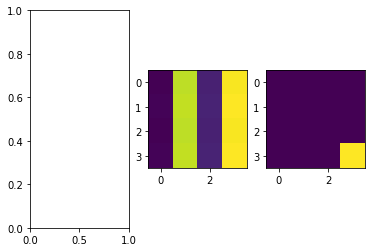

In [113]:
fig, (ax_input, ax_output, ax_single) = plt.subplots(1, 3)

ax_output.imshow(test_classif)
ax_single.imshow(test_classif == risk_thresh)
